In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_pickle('data.pkl')

In [3]:
data.set_index('state_county', inplace=True)

In [4]:
def get_label(x):
    if x<=14.91:
        label=0
    elif 14.91<x<=16.68:
        label=1
    elif 16.68<x<=18.37:
        label=2
    else:
        label=3
    return label

In [5]:
data['label'] = data['Readmission Rate (outcome)'].apply(get_label)

In [6]:
data.drop(['Drug Overdose Deaths per 100,000','Percent Residential Segregation Black/White','Homicides','Percent Non-Hispanic White'], axis=1, inplace=True)

In [7]:
data.fillna(data.mean(), inplace=True)

# Normalization + PCA + Kmeans

### Normalization

In [8]:
from sklearn import preprocessing
feature = data.columns.drop(['label'])
X = np.array(data[feature])
y = data.label

# initiate scalers
scaler1 = preprocessing.StandardScaler()
scaler2 = preprocessing.MinMaxScaler()  
scaler3 = preprocessing.Normalizer(norm='l2')
# apply scalers to original features
X_norm1 = scaler1.fit_transform(X)
X_norm2 = scaler2.fit_transform(X)
X_norm3 = scaler3.fit_transform(X)

### PCA

In [9]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

def purity_score(y_true, y_pred):
    y_voted_labels = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)
    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    return accuracy_score(y_true, y_voted_labels), y_voted_labels

def kmeans_purity(X, method):
    estimator = KMeans(n_clusters=4, init=method, n_init=10, random_state=0).fit(X)
    accuracy = purity_score(y, estimator.labels_)
    print('accuracy =', accuracy[0])
    pd.DataFrame(estimator.labels_).to_pickle('y_pred_purity.pkl')

In [10]:
def pca_2D_visualization(x, y, title=''):
    pca = PCA(n_components = x.shape[1]).fit_transform(x)
    df = pd.DataFrame(data = pca[:,:2])
    df['label'] = np.array(y)
    plt.axis('equal')
    plt.scatter(df[0][df['label']==0], df[1][df['label']==0], c='g', edgecolor='k', alpha=0.6)
    plt.scatter(df[0][df['label']==1], df[1][df['label']==1], c='r', edgecolor='k', alpha=0.6)
    plt.scatter(df[0][df['label']==2], df[1][df['label']==2], c='y', edgecolor='k', alpha=0.6)
    plt.scatter(df[0][df['label']==3], df[1][df['label']==3], c='b', edgecolor='k', alpha=0.6)
    plt.xlabel('first component')
    plt.ylabel('second component')
    plt.title(title)
    plt.show()
    
    #estimator = KMeans(n_clusters=4, init=method, n_init=10, random_state=0).fit(X)
    #accuracy = purity_score(y, estimator.labels_)
    #print('accuracy =', accuracy[0]

In [11]:
from mpl_toolkits.mplot3d import Axes3D
def pca_3D_visualization(x, y, title=''):
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    pca = PCA(n_components = X_norm1.shape[1]).fit_transform(X_norm1)
    df = pd.DataFrame(data = pca[:,:3])
    ax.scatter(df[0], df[1], df[2], c=y, 
               cmap=plt.cm.Set1, edgecolor='k', s=40)#s is the number of pixels, size of the points
    ax.set_title("First three PCA directions"+title) # X is 1st component, Y is 2nd, Z is 3rd
    ax.set_xlabel("1st eigenvector")
    ax.set_ylabel("2nd eigenvector")
    ax.set_zlabel("3rd eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    plt.show()

In [12]:
kmeans_purity(X_norm1, 'k-means++')
y_pred = pd.read_pickle('y_pred_purity.pkl')

accuracy = 0.4049079754601227


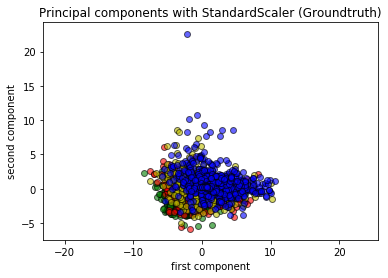

In [13]:
pca_2D_visualization(X_norm1, y, title='Principal components with StandardScaler (Groundtruth)')

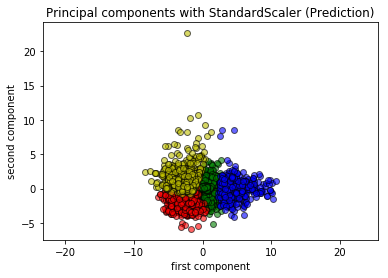

In [14]:
pca_2D_visualization(X_norm1, y_pred, title='Principal components with StandardScaler (Prediction)')

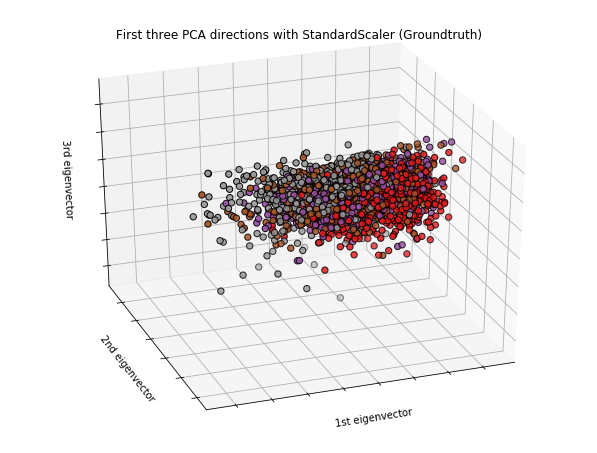

In [15]:
pca_3D_visualization(X_norm1, y, title=' with StandardScaler (Groundtruth)')

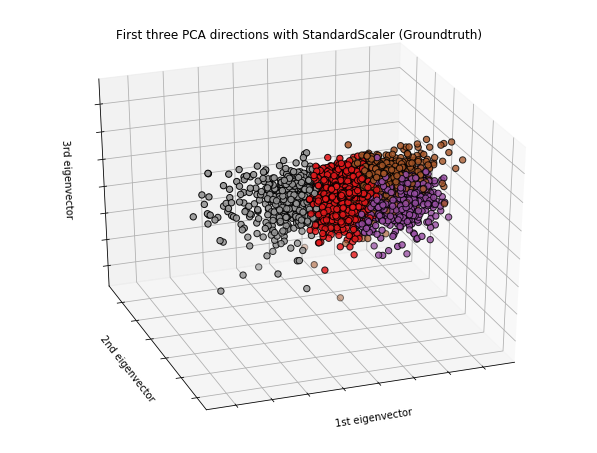

In [16]:
pca_3D_visualization(X_norm1, pd.Series(y_pred[0]), title=' with StandardScaler (Groundtruth)')

In [17]:
kmeans_purity(X_norm2, 'k-means++')
y_pred = pd.read_pickle('y_pred_purity.pkl')

accuracy = 0.38650306748466257


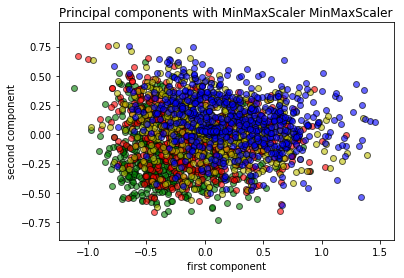

In [18]:
pca_2D_visualization(X_norm2, y, title='Principal components with MinMaxScaler MinMaxScaler')

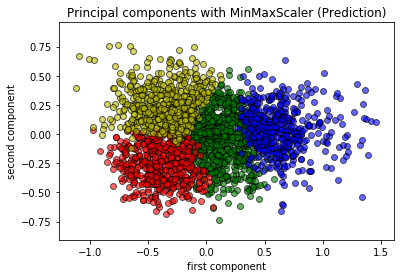

In [19]:
pca_2D_visualization(X_norm2, y_pred, title='Principal components with MinMaxScaler (Prediction)')

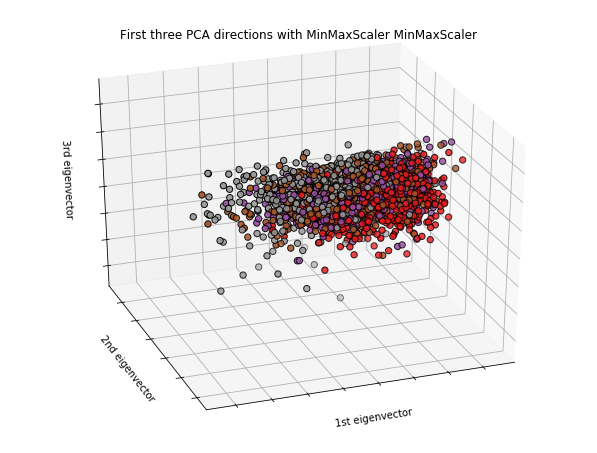

In [20]:
pca_3D_visualization(X_norm2, y, title=' with MinMaxScaler MinMaxScaler')

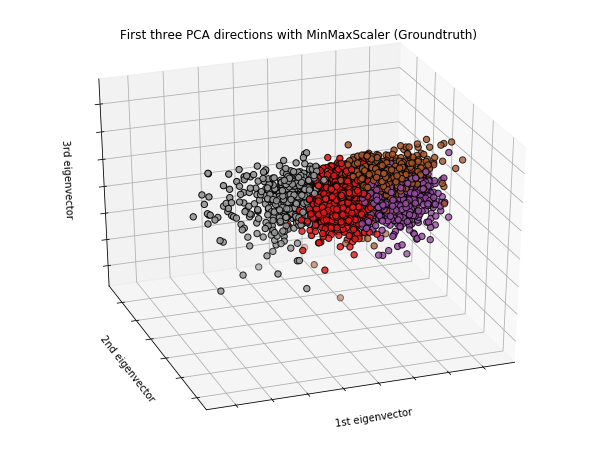

In [21]:
pca_3D_visualization(X_norm2, pd.Series(y_pred[0]), title=' with MinMaxScaler (Groundtruth)')

In [22]:
kmeans_purity(X_norm3, 'k-means++')
y_pred = pd.read_pickle('y_pred_purity.pkl')

accuracy = 0.3619631901840491


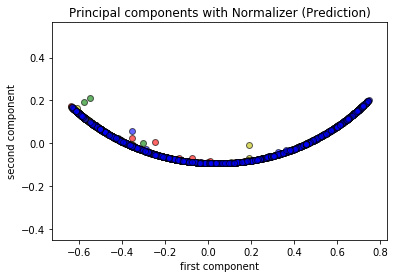

In [23]:
pca_2D_visualization(X_norm3, y, title='Principal components with Normalizer (Prediction)')

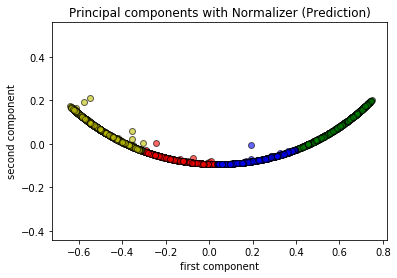

In [24]:
pca_2D_visualization(X_norm3, y_pred, title='Principal components with Normalizer (Prediction)')

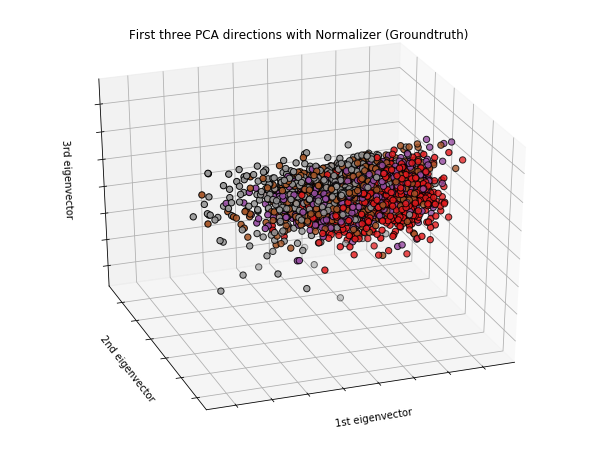

In [25]:
pca_3D_visualization(X_norm3, y, title=' with Normalizer (Groundtruth)')

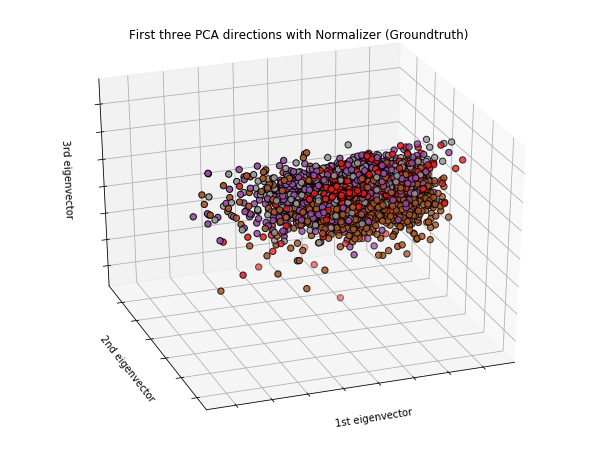

In [26]:
pca_3D_visualization(X_norm3, pd.Series(y_pred[0]), title=' with Normalizer (Groundtruth)')

### 5 fold cross-validation and gridsearch for best parameters (PCA+Kmeans)

In [35]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import silhouette_score

folds=5
k_fold = KFold(n_splits=folds, shuffle=True, random_state=0)

bin_params = {
    "n_init": range(10,100),
    "max_iter": [100, 200, 300, 400, 500],
    "tol": [.0000001, .000001, .00001, .0001],
}

bin_k_means = KMeans(n_clusters=2)  # set 2 clusters

binary_ensemble = GridSearchCV(
    estimator=bin_k_means,
    param_grid=bin_params,
    cv=k_fold,
)

def para_tune(X):
    binary_ensemble.fit(X)  # fit model to data and return best model
    # Generate labels for data with model with raw data, compute score
    bin_labels = binary_ensemble.predict(X)
    bin_score1 = purity_score(y, bin_labels)[0]
    bin_score2 = silhouette_score(X, bin_labels)
    print('accuracy =', bin_score1)
    print('silhouette_score = ', bin_score2)
    print(binary_ensemble.best_params_)

# tune parameters for three normalizers
para_tune(X_norm1)
para_tune(X_norm2)
para_tune(X_norm3)

accuracy = 0.3623721881390593
silhouette_score =  0.17305312866781375
{'max_iter': 100, 'n_init': 10, 'tol': 1e-07}
accuracy = 0.3558282208588957
silhouette_score =  0.19740346160726843
{'max_iter': 100, 'n_init': 79, 'tol': 1e-05}
accuracy = 0.3337423312883436
silhouette_score =  0.6257929683851922
{'max_iter': 100, 'n_init': 77, 'tol': 1e-07}


### Determine best number of clusters

In [36]:
pca = PCA(n_components = X_norm1.shape[1]).fit_transform(X_norm1)
df = pd.DataFrame(data = pca[:,:2])
estimator = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=0).fit(df)
accuracy = purity_score(y, estimator.labels_)
accuracy[0]

0.41063394683026583

In [37]:
from sklearn.cluster import KMeans
import numpy as np

distorsions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df)
    distorsions.append(kmeans.inertia_)

#plt.plot(range(1, 10), distorsions)
#plt.grid(True)
#plt.title('Elbow curve')
#plt.ylabel('Sum of squared distances from samples to clusters')
#plt.xlabel('Number of clusters')
#plt.show()